In [93]:
import librosa
import numpy as np
# Monkey patch to fix pgmpy error
if not hasattr(np, 'product'):
    np.product = np.prod
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
import soundfile as sf
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from scipy.io import wavfile
from scipy.fft import fftfreq, ifft
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder

In [94]:
# checking audio channels due to signal processing principles
sample_rate, audio_signal= wavfile.read('/Users/yusufabdullahi/Desktop/uni_lincoln/research-methods/Dataset_PCG_signals/Original_signal/78_participants_7_segment/Participant_02/segment_3.wav')
print(sample_rate, audio_signal)
print(len(audio_signal))

L = len(audio_signal)
Fs = sample_rate
dt = 1 / Fs
t = np.arange(0, L/sample_rate, dt)
audio_length = L / sample_rate

2000 [-32 -34 -35 ... 112  92  74]
20000


Text(0, 0.5, 'Amplitude')

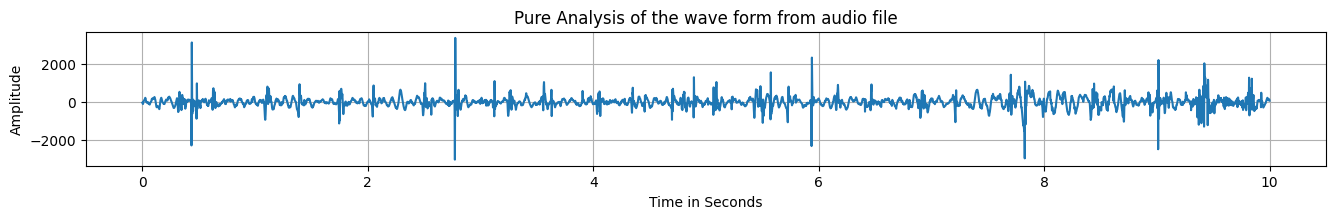

In [95]:
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1) 
plt.title('Pure Analysis of the wave form from audio file')
plt.plot(t, audio_signal)
plt.grid()
plt.xlabel('Time in Seconds')
plt.ylabel('Amplitude')

In [96]:
signal_fft = np.fft.fft(audio_signal)
# spicy_analysis = sp.fft(data)

# to remove noise
low_freq = 50
high_freq = 4000

frequencies = np.fft.fftfreq(L, d=dt)
print(np.max(frequencies))

filtered_fft = signal_fft.copy()
filtered_fft[(frequencies < low_freq) | (frequencies > high_freq)] = 0



999.9000000000001


Text(0, 0.5, 'Magnitude')

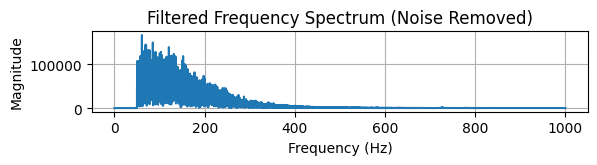

In [97]:
plt.subplot(4, 1, 2)
plt.title("Filtered Frequency Spectrum (Noise Removed)")
plt.plot(frequencies[:L//2], np.abs(filtered_fft[:L//2]))
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

In [98]:
filtered_signal = ifft(filtered_fft)

normalized_filtered_signal = np.real(filtered_signal)
normalized_filtered_signal = normalized_filtered_signal / np.max(np.abs(normalized_filtered_signal))

# Convert to int16 format for saving
output_signal = (normalized_filtered_signal * 32767).astype(np.int16)

# Save the filtered signal as a new wav file
wavfile.write('filtered_audio.wav', sample_rate, output_signal)


Text(0, 0.5, 'Magnitude')

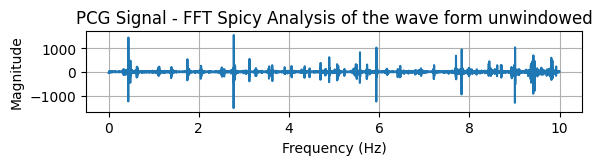

In [123]:

plt.subplot(4, 1, 3) 
# plt.plot(positive_frequencies,positive_fft_magnitudes)
plt.plot(t, np.real(filtered_signal))
# plt.figure(1)
# plt.figure(figsize=(10, 4))
plt.title('PCG Signal - FFT Spicy Analysis of the wave form unwindowed')
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

In [99]:
# 1. Load PCG signal
def load_pcg(path):
    signal, sr = librosa.load(path, sr=1000)  # downsample to 1kHz
    return signal, sr

# 2. Feature Extraction
def extract_features(signal, sr):
    energy = np.sum(signal ** 2)
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr))
    return [energy, zero_crossings, spectral_centroid]

# 3. Discretization
def discretize_features(data, n_bins=3):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    return discretizer.fit_transform(data)

# 4. Example Dataset
# Simulate dataset (replace with a loop over your own PCG files)
X = []
y = []
for i in range(10):  # simulate 10 files
    signal =  load_pcg("/Users/yusufabdullahi/Desktop/uni_lincoln/research-methods/Dataset_PCG_signals/Original_signal/78_participants_7_segment/Participant_02/segment_3.wav")[0]
    features = extract_features(signal, 1000)
    label = 1 if i < 5 else 0  # Simulate labels
    X.append(features)
    y.append(label)


In [121]:
# 1. Load the data
df = pd.read_excel("/Users/yusufabdullahi/Desktop/uni_lincoln/research-methods/Dataset_PCG_signals/Information_78_participant.xlsx")  # Update with actual path if needed

# 2. Define features and label
features = ['pluse', 'PtP', 'W', 'H', 'age']
label = 'gender'


# 3. Discretize features
X = df[features].values
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_disc = discretizer.fit_transform(X).astype(int)

# 4. Encode label
y = LabelEncoder().fit_transform(df[label])
y = y.reshape(-1, 1)

# 5. Combine into one DataFrame
all_data = pd.DataFrame(np.hstack((X_disc, y)), columns=features + [label])
all_data = all_data.astype(int)  # Ensure all values are int for pgmpy

# 6. Build Bayesian Network
edges = [(feature, label) for feature in features]
model = BayesianModel(edges)
model.fit(all_data, estimator=MaximumLikelihoodEstimator)

# 7. Inference
inference = VariableElimination(model)

# Check unique values to pick valid evidence for query
print("Unique values for 'pluse':", all_data['pluse'].unique())
print("Unique values for 'age':", all_data['age'].unique())

# 8. Query example
query_result = inference.query(
    variables=[label],
    evidence={'pluse': 1, 'age': 1}
)
print(query_result)

Unique values for 'pluse': [1 2 0]
Unique values for 'age': [0 2 1]


Eliminating: PtP: 100%|██████████| 3/3 [00:00<00:00, 1950.84it/s]

+-----------+---------------+
| gender    |   phi(gender) |
+===========+===============+
| gender(0) |        0.5234 |
+-----------+---------------+
| gender(1) |        0.4766 |
+-----------+---------------+


In [120]:

# -- Example placeholder function (you likely have this already) --
def discretize_features(X, n_bins=3):
    disc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    return disc.fit_transform(X)

# -- Assuming X and y are already loaded from some process --
X = np.array(X)
y = np.array(y).reshape(-1, 1)

# Discretize features
X_disc = discretize_features(X)

# Combine into DataFrame
df = pd.DataFrame(np.hstack((X_disc, y)), columns=['Energy', 'ZeroCrossings', 'Centroid', 'Label'])

# Ensure all columns are integer-typed (important for pgmpy)
df = df.astype(int)

# Build Bayesian Model
model = BayesianModel([('Energy', 'Label'), ('ZeroCrossings', 'Label'), ('Centroid', 'Label')])
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Inference
inference = VariableElimination(model)
query_result = inference.query(variables=['Label'], evidence={'Energy': 2, 'ZeroCrossings': 1})
print(query_result)

ValueError: Shape of passed values is (78, 6), indices imply (78, 4)